Trabalho Computacional 1: Distribuição de Energia Elétrica

Alunos:

Izaias Façanha de Sousa - 496933

Iago Bastos da Silva Aguiar - 472174

**1)**

In [1]:
  #Para utilizar o OpenDSS via PY é necessário instalar a bibilioteca "OpenDSSDirect.py"
  !pip install 'OpenDSSDirect.py[extras]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.0/392.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 8.6 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from opendssdirect import dss
from dss import plot
plot.enable()

In [3]:
#Os arquivos OpenDSS se encontram no Google Drive Pessoal:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [4]:
#Carregando o Arquivo "Master.dss":
dss('Redirect "/content/MyDrive/MyDrive/LVTestCase/Master.dss"')

In [5]:
#A priori é configurado o modo snapshot para a visualização do circuito de
#distribuição e plotagem da queda de tensão ao longo do alimentador:
dss('set mode =snapshot')
dss('solve')

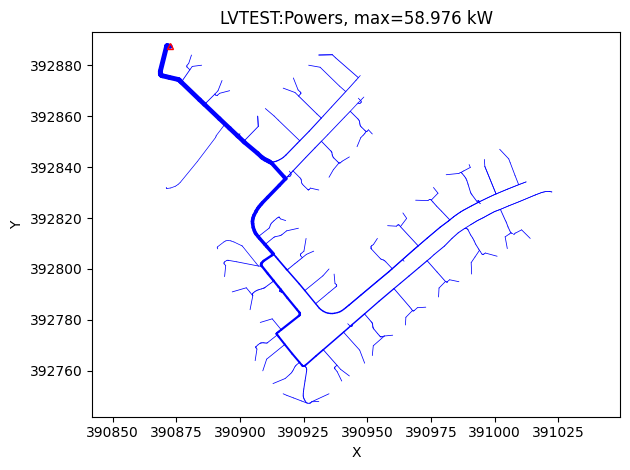

In [6]:
dss('Set MarkTransformers=Yes')
dss('Plot circuit')

 Na figura acima está destacado o tronco do alimentador, ligados a ele estão representados os ramais de derivação.

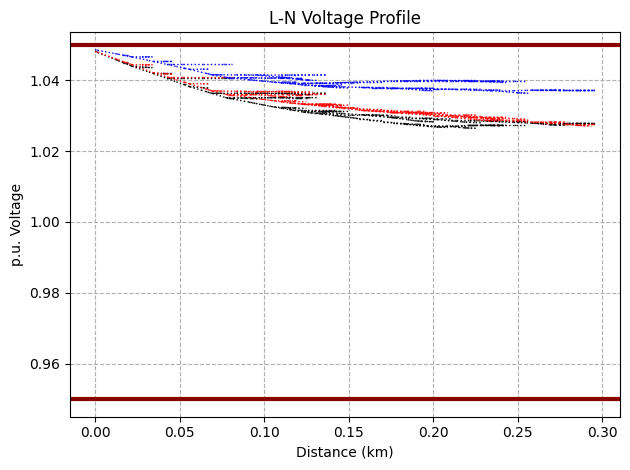

In [ ]:
dss('Plot profile')

 O gráfico acima representa o comportamento da tensão ao longo do alimentador. Uma vez que a queda e tensão pode ser simplificada como:

 $$\Delta V = Z * I $$
  E em cabos:

 $$Z_{cond} = z * L$$

 Sendo L o comprimento de um condutor.

Quanto mais distante do início do alimentador, maior a impedância acumulada de cabos e maior também o número de cargas conectadas à rede, contribuindo para a queda de tensão.

In [7]:
#Para a visualização da Magnitude da Potência Aparente e da Tensão no início do
#Alimentador, foram criados dois elementos "Monitor":

In [8]:
dss('New Monitor.alimentador_Potencia_kW Element=Line.LINE1 Mode=1 ppolar=0')
dss('New Monitor.alimentador_Tensao_kV Element=Line.LINE1 Mode=0 ppolar=0')



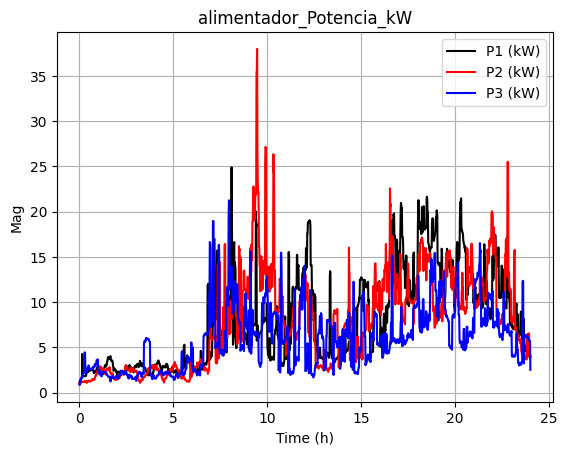

In [9]:
dss('Solve Mode=yearly,number= 1440 stepsize=1m    ! one day simulation')
dss('Plot Monitor Object=alimentador_Potencia_kW')



In [10]:
#Para acessar os resultados, os dados de potência
#foram exportados em formato csv:

In [11]:
DSSText = dss('Export monitor alimentador_Potencia_kW')
myPath = DSSText

In [14]:
#Convertendo o arquivo csv em DataFrame
df = pd.read_csv('/content/LVTest_Mon_alimentador_potencia_kw_1.csv')

In [15]:
df

,hour,t(sec),P1 (kW),Q1 (kvar),P2 (kW),Q2 (kvar),P3 (kW),Q3 (kvar)
0,0,60.0,1.15037,0.377868,1.00888,0.331611,0.888152,0.291794
1,0,120.0,1.15040,0.377847,1.04151,0.342335,0.863108,0.283588
2,0,180.0,1.22541,0.402512,1.04155,0.342362,0.972012,0.319311
3,0,240.0,1.45389,0.477641,1.04162,0.342410,1.160350,0.381050
4,0,300.0,1.51909,0.499246,1.10704,0.363802,1.467050,0.481644
...,...,...,...,...,...,...,...,...
1435,23,3360.0,4.04438,1.325700,6.54407,2.140010,5.785900,1.902450
1436,23,3420.0,4.27070,1.403700,4.14840,1.360670,5.717760,1.872670
1437,23,3480.0,4.12332,1.355530,4.04598,1.326660,5.717320,1.872910
1438,23,3540.0,3.82046,1.256300,4.04607,1.326180,5.716690,1.873180


In [21]:
#Selecionando apenas a potência ativa trifásica:
trafo_df = df.iloc[:,[2,4,6]]
p3_trafo = trafo_df.sum(axis=1).to_frame(name='Potência Ativa (kW)')
p3_trafo

,Potência Ativa (kW)
0,3.047402
1,3.055018
2,3.238972
3,3.655860
4,4.093180
...,...
1435,16.374350
1436,14.136860
1437,13.886620
1438,13.583220


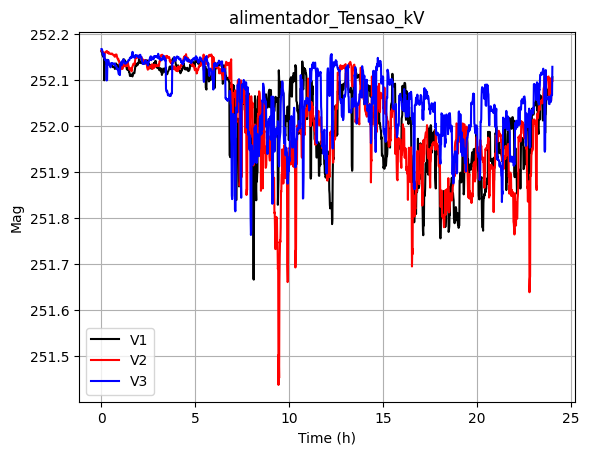

In [ ]:
dss('Plot Monitor Object=alimentador_Tensao_kV')


Para realizar as análises requeridas(Demanda,Energia,etc) é necessário obter as potências para cada carga durante o intervalo de 24h.

O circuito apresenta 55 cargas, cada carga está associada a um perfil de carga. O arquivo "loadshape" possui na coluna "Pmult" os múltiplos da potência de cada carga.

Como cada carga possui 1kW, cada um dos 1440 elementos em cada linha da coluna "Pmult" representa a potência consumida pela carga no intervalo de 1 minuto.


In [22]:
#DataFrame indicando as 55 cargas do sistema e suas potências
dss.utils.loads_to_dataframe()

,Name,Idx,Phases,Class,Model,NumCust,IsDelta,Rneut,Xneut,PF,...,kV,kW,kVABase,kvar,kWh,kWhDays,AllocationFactor,XfkVA,puSeriesRL,Sensor
load1,load1,1,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load2,load2,2,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load3,load3,3,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load4,load4,4,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load5,load5,5,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load6,load6,6,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load7,load7,7,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load8,load8,8,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load9,load9,9,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1
load10,load10,10,1,1,1,1,False,-1.0,0.0,0.95,...,0.23,1.0,1.052632,0.328684,0.0,30.0,0.5,0.0,50.0,line.line1


In [224]:
#DataFrame com os 55 perfis de Carga
load_shape = dss.utils.loadshape_to_dataframe()
load_shape

,Name,Idx,UseActual,Npts,HrInterval,MinInterval,SInterval,PBase,PMult,QBase,QMult,TimeArray
default,default,1,False,24,1.0,60.0,3600.0,0.0,"[0.677, 0.6256, 0.6087, 0.5833, 0.58028, 0.602...",0.0,[0.0],[0.0]
shape_1,shape_1,2,False,1440,0.016667,1.0,60.0,0.0,"[0.036, 0.036, 0.036, 0.036, 0.036, 0.036, 0.0...",0.0,[0.0],[0.0]
shape_2,shape_2,3,False,1440,0.016667,1.0,60.0,0.0,"[0.044, 0.044, 0.044, 0.044, 0.044, 0.044, 0.0...",0.0,[0.0],[0.0]
shape_3,shape_3,4,False,1440,0.016667,1.0,60.0,0.0,"[0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.0...",0.0,[0.0],[0.0]
shape_4,shape_4,5,False,1440,0.016667,1.0,60.0,0.0,"[0.048, 0.048, 0.048, 0.227, 0.227, 0.227, 0.2...",0.0,[0.0],[0.0]
shape_5,shape_5,6,False,1440,0.016667,1.0,60.0,0.0,"[0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.1...",0.0,[0.0],[0.0]
shape_6,shape_6,7,False,1440,0.016667,1.0,60.0,0.0,"[0.052, 0.052, 0.052, 0.052, 0.052, 0.052, 0.0...",0.0,[0.0],[0.0]
shape_7,shape_7,8,False,1440,0.016667,1.0,60.0,0.0,"[0.055, 0.055, 0.055, 0.055, 0.055, 0.055, 0.0...",0.0,[0.0],[0.0]
shape_8,shape_8,9,False,1440,0.016667,1.0,60.0,0.0,"[0.043, 0.043, 0.043, 0.043, 0.043, 0.043, 0.0...",0.0,[0.0],[0.0]
shape_9,shape_9,10,False,1440,0.016667,1.0,60.0,0.0,"[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.0...",0.0,[0.0],[0.0]


In [24]:
#Selecionando apenas a coluna 8 ,que possui os múltiplos das potências das Cargas
loads = load_shape.iloc[1:, 8]


In [25]:
#Gerando um DF novo onde cada Linha é um intervalo de tempo e cada Coluna é uma Carga
loads_df = pd.DataFrame()
for i in range(len(loads)):
    loads_df[i] = loads.iloc[i]

In [26]:
loads_df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.036,0.044,0.054,0.048,0.035,0.052,0.055,0.043,0.059,0.057,...,0.062,0.045,0.046,0.054,0.052,0.053,0.052,0.047,0.048,0.055
1,0.036,0.044,0.054,0.048,0.035,0.052,0.055,0.043,0.059,0.057,...,0.062,0.045,0.046,0.054,0.052,0.053,0.052,0.047,0.048,0.055
2,0.036,0.044,0.054,0.048,0.035,0.052,0.055,0.043,0.059,0.057,...,0.122,0.045,0.046,0.054,0.052,0.053,0.052,0.047,0.057,0.055
3,0.036,0.044,0.054,0.227,0.035,0.052,0.055,0.043,0.059,0.057,...,0.162,0.045,0.046,0.054,0.052,0.053,0.052,0.047,0.048,0.055
4,0.036,0.044,0.054,0.227,0.035,0.052,0.055,0.043,0.059,0.057,...,0.222,0.045,0.046,0.054,0.052,0.053,0.052,0.047,0.048,0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.036,1.136,0.548,0.048,0.347,0.052,0.055,3.395,0.281,0.169,...,0.049,0.472,0.046,0.054,0.310,0.053,0.217,0.047,0.048,0.055
1436,0.036,1.136,0.548,0.048,0.347,0.052,0.055,3.395,0.281,0.169,...,0.049,0.407,0.046,0.054,0.310,0.053,0.544,0.047,0.048,0.055
1437,0.036,0.982,0.561,0.048,0.347,0.052,0.055,3.395,0.281,0.169,...,0.049,0.407,0.046,0.054,0.310,0.053,0.544,0.047,0.048,0.055
1438,0.036,0.982,0.471,0.048,0.347,0.052,0.055,3.395,0.281,0.169,...,0.049,0.407,0.046,0.054,0.310,0.053,0.544,0.047,0.048,0.055


A Demanda é definida como:
$$
D = \frac{1}{T} \sum_{n=1}^{N} p_n \cdot \Delta t_n
$$

Sendo necessário encontrar uma Potência Média a cada 15 minutos, e sabendo que cada intervalo do DF representa 1 minuto, a fórmula é simplificada:
$$
D = \frac{1}{15} \sum_{n=1}^{15} p_n
$$

In [27]:
#Execução do Cálculo da Demanda
loads_df_new = loads_df.groupby(np.arange(loads_df.shape[0]) // 15).mean()
loads_df_new

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.036000,0.044000,0.054000,0.191200,0.073667,0.052000,0.055000,0.043000,0.0590,0.057000,...,0.176800,0.045000,0.046000,0.121333,0.052000,0.0530,0.052000,0.047000,0.214133,0.055000
1,0.036000,0.044000,0.054000,0.228333,0.035000,0.052000,0.055000,0.054333,0.1774,0.057000,...,0.175000,0.045000,0.046000,0.256000,0.052000,0.0530,0.052000,0.047000,0.048000,0.070867
2,0.036000,0.085067,0.054000,0.165667,0.221667,0.052000,0.055000,0.190333,0.2662,0.057000,...,0.352133,0.045000,0.046000,0.094133,0.052000,0.0530,0.052000,0.047000,0.116400,0.174000
3,0.160800,0.198000,0.054000,0.166000,0.035000,0.052000,0.106333,0.116733,0.0590,0.057000,...,0.381600,0.120200,0.046000,0.153000,0.086400,0.0530,0.270533,0.047000,0.219000,0.062933
4,0.209600,0.054267,0.054000,0.063733,0.035000,0.052000,0.209000,0.316333,0.0590,0.057000,...,0.391467,0.233000,0.046000,0.060600,0.310000,0.0530,0.242400,0.047000,0.059400,0.055000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.384933,0.789933,0.440000,0.203133,0.580000,0.175733,3.997933,0.201667,0.1034,0.693000,...,1.305600,0.679333,0.209333,1.932200,0.557200,0.0530,0.052000,0.133800,1.031000,0.055000
92,0.332800,1.008933,0.791067,0.202600,0.501200,0.268533,0.696000,0.174067,0.0590,0.497533,...,0.279733,0.687333,0.053200,0.410000,0.355000,0.0530,0.111000,0.233000,0.800200,0.260000
93,0.254000,1.146133,1.066733,0.179000,0.423600,0.052000,0.681733,0.602533,0.1170,0.057000,...,0.214600,0.553800,0.154000,0.477000,0.052000,0.1058,0.378333,0.205333,0.705133,0.182400
94,0.192000,1.114800,1.152133,0.182200,0.475333,0.052000,0.055000,3.332933,0.3070,0.086867,...,0.049000,0.432333,0.060400,0.202133,0.052000,0.1190,0.075600,0.047000,0.532000,0.166067


2)

In [28]:
# Selecionando 20 consumidores aleatórios
sel_20 = np.random.choice(loads_df_new.columns, size=20, replace=False)
loads_20_df = pd.DataFrame(columns=range(20))
loads_20_df = loads_df_new[sel_20]
loads_20_df.columns = range(0, 20)

In [29]:
loads_20_df = loads_20_df.T
loads_20_df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.044000,0.044000,0.085067,0.198000,0.054267,0.130267,0.323467,0.207667,0.063400,0.136400,...,0.895733,1.006467,0.971067,0.730933,0.801267,0.789933,1.008933,1.146133,1.114800,1.506200
1,0.036000,0.036000,0.036000,0.160800,0.209600,0.105600,0.036000,0.036000,0.036000,0.080267,...,0.421067,0.344000,0.408000,0.514400,0.546667,0.384933,0.332800,0.254000,0.192000,0.098400
2,0.053000,0.121000,0.223000,0.064333,0.053000,0.053000,0.053000,0.053000,0.098333,0.223000,...,0.685333,1.134667,0.679667,0.758600,0.732000,0.854467,0.719667,0.506600,0.362600,0.053000
3,0.034000,0.034000,0.034000,0.034000,0.173200,0.150000,0.034000,0.034000,0.034000,0.080400,...,0.584733,0.682200,0.858333,0.299667,0.034000,0.034000,0.150000,0.173200,0.034000,0.034000
4,0.045000,0.045000,0.045000,0.120200,0.233000,0.100333,0.130600,0.045000,0.132733,0.233000,...,0.200600,0.207933,0.420333,0.419000,0.551000,0.679333,0.687333,0.553800,0.432333,0.462667
5,0.052000,0.052000,0.052000,0.052000,0.139200,0.283400,0.308200,0.077200,0.052000,0.081067,...,0.131933,0.077200,0.241000,0.202200,0.182000,0.157600,0.052000,0.081067,0.342733,0.236200
6,0.029000,0.029000,0.098333,0.084467,0.214733,0.135133,0.029000,0.070600,0.112200,0.055533,...,0.927067,0.760800,0.029000,0.029000,0.029000,0.029000,0.216533,0.258133,0.029000,0.029000
7,0.049000,0.049000,0.049000,0.049000,0.049000,0.255267,0.166867,0.049000,0.049000,0.070467,...,0.958067,0.887400,0.927467,0.900000,0.980533,1.027400,0.166867,0.049000,0.156333,0.156333
8,0.057000,0.147067,0.183733,0.152333,0.057000,0.057000,0.198533,0.132267,0.152333,0.057000,...,0.501667,0.524400,0.788600,0.318800,0.268133,0.158000,0.057000,0.057000,0.057000,0.211400
9,0.054000,0.124667,0.188867,0.169000,0.069333,0.054000,0.110533,0.233667,0.153667,0.054000,...,0.547667,0.554733,0.616867,0.555667,0.734867,0.615667,0.107667,0.138333,0.054000,0.054000


In [30]:
#Curvas de Demanda:

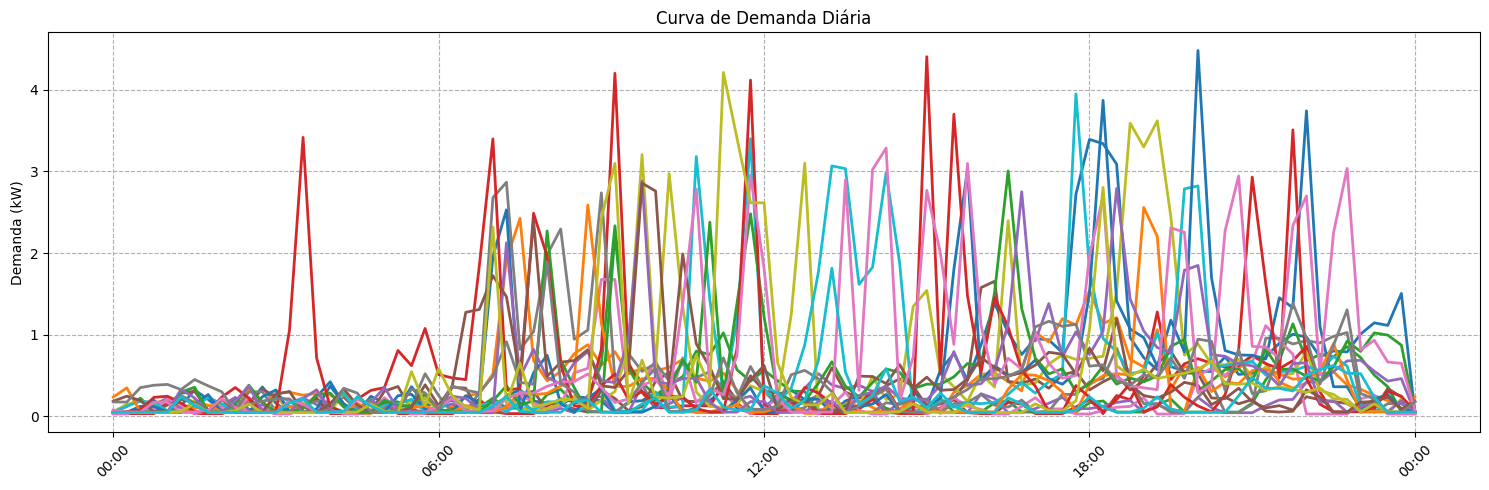

In [33]:

horas = [f'{h:02d}:{m:02d}' for h in range(24) for m in [0, 15, 30, 45]]


cargas_df_loop = pd.concat([loads_20_df, loads_20_df.iloc[:, [0]]], axis=1)


x_plot = np.arange(97)
plt.figure(figsize=(15, 5))


for i in range(cargas_df_loop.shape[0]):
    plt.plot(
        x_plot,
        cargas_df_loop.iloc[i],
        linestyle='-',
        linewidth=2,
        label=f'Cons {i}'
    )


ticks_pos = list(range(0, 97, 24))
ticks_labels = [horas[i] if i < 96 else '00:00' for i in ticks_pos]
plt.xticks(ticks_pos, ticks_labels, rotation=45)


plt.ylabel('Demanda (kW)')
plt.title('Curva de Demanda Diária')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

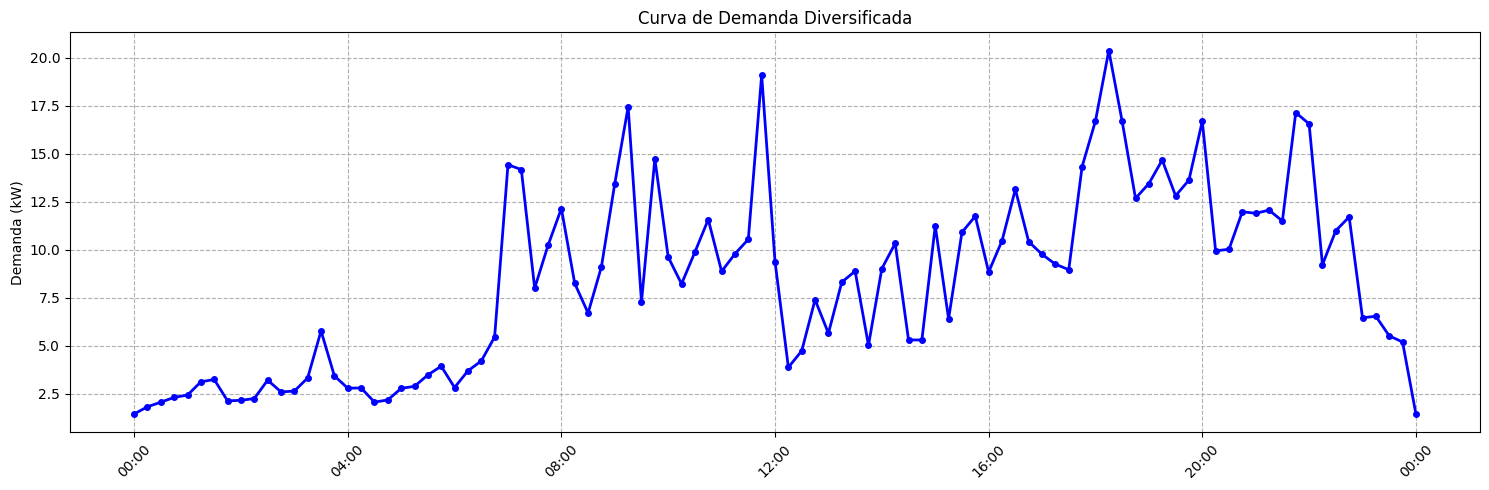

In [34]:


# 1. Calcular a demanda diversificada (soma dos consumidores)
total = loads_20_df.sum(axis=0)


horas = [f'{h:02d}:{m:02d}' for h in range(24) for m in [0, 15, 30, 45]]


total_loop = np.append(total, total.iloc[0])
horas_loop = horas + ['00:00']


x_plot = np.arange(97)


plt.figure(figsize=(15, 5))
plt.plot(
    x_plot,
    total_loop,
    color='blue',
    linewidth=2,
    marker='o',
    markersize=4
)


ticks_pos = list(range(0, 97, 16))
ticks_labels = [horas_loop[i] if i < 96 else '00:00' for i in ticks_pos]
plt.xticks(ticks_pos, ticks_labels, rotation=45)


plt.ylabel('Demanda (kW)')
plt.title('Curva de Demanda Diversificada')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

In [35]:
#Código para melhor visualização de um DataFrame
def p_df(df):

    from IPython.display import display

    display(df.style
        .format("{:.6f}")
        .set_properties(**{
            'background-color': 'white',
            'color': 'black',
            'border-color': 'black',
            'text-align': 'center',
            'font-size': '14px'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', 'white'),
                ('color', 'black'),
                ('border', '1px solid black'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('border', '1px solid black')
            ]}
        ])
    )

In [36]:
#Demanda Máxima para Cada Consumidor:
dmax = loads_20_df.max(axis=1)
#Demanda Média para Cada Consumidor:
dmean = loads_20_df.mean(axis=1)
#Energia Consumida para cada consumidor:
kwh = dmean * 24
#Fator de Carga para cada consumidor:
FC = dmean.div(dmax)
#-----------------------------------------------------------------------------#
results_1 = pd.concat([dmax,dmean,kwh,FC],axis=1)
results_1.columns=["Demanda Máxima(kW)","Demanda Média(kW)","Energia Consumida(kWh)","Fator de Carga"]
results_1.index = [f"Consumidor {i}" for i in range(len(results_1))]
p_df(results_1)

,Demanda Máxima(kW),Demanda Média(kW),Energia Consumida(kWh),Fator de Carga
Consumidor 0,3.393133,0.504167,12.100017,0.148585
Consumidor 1,2.426200,0.425978,10.223483,0.175574
Consumidor 2,2.335000,0.255344,6.128267,0.109355
Consumidor 3,4.203000,0.235055,5.641317,0.055925
Consumidor 4,0.687333,0.170957,4.102967,0.248725
Consumidor 5,1.655267,0.278645,6.687483,0.168339
Consumidor 6,1.677000,0.216189,5.188533,0.128914
Consumidor 7,2.868067,0.419797,10.075117,0.146369
Consumidor 8,3.620333,0.569886,13.677267,0.157413
Consumidor 9,3.951267,0.610722,14.657317,0.154563


In [37]:
#Demanda Máxima para o conjunto de 20 consumidores selecionados
dmaxtotal = loads_20_df.sum(axis=0).max()
#Demanda Média para o conjunto de 20 consumidores selecionados
dmeantotal = loads_20_df.sum(axis=0).mean()
#Energia Consumida para o conjunto de 20 consumidores selecionados
kwh_total = kwh.sum(axis=0)
#Fator de Carga Total
FCtotal = dmeantotal/dmaxtotal
#-----------------------------------------------------------------------------#
results_2 = pd.concat([
    pd.Series([dmaxtotal], name="Demanda Máxima(kW)"),
    pd.Series([dmeantotal], name="Demanda Média(kW)"),
    pd.Series([kwh_total], name="Energia Consumida(kWh)"),
    pd.Series([FCtotal], name="Fator de Carga")
], axis=1)
results_2.index = ["Total"]
p_df(results_2)


,Demanda Máxima(kW),Demanda Média(kW),Energia Consumida(kWh),Fator de Carga
Total,20.367800,8.426550,202.237200,0.413719


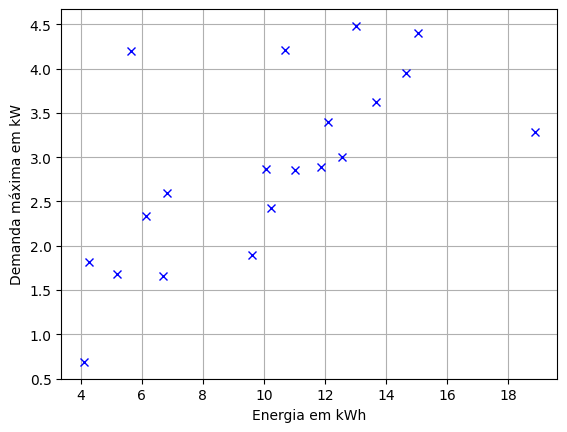

In [38]:
#O gráfico abaixo relaciona para cada consumidor sua Energia Consumida
#e sua Demanda Máxima

plt.plot(kwh , dmax, 'bx')
plt.xlabel('Energia em kWh')
plt.ylabel('Demanda máxima em kW')
plt.grid(True)

In [39]:
#Código para gerar uma reta de ajuste para os pontos calculados anteriormente:
x = kwh.to_numpy(float)
y = dmax.to_numpy(float)

# definição dos coeficientes da regressão polinomial
z = np.polyfit(x, y, 1)
p1 = np.poly1d(z)
p1

poly1d([0.16942175, 1.19948763])

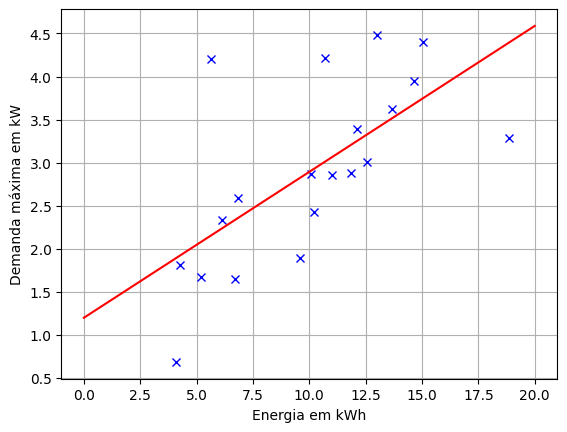

In [41]:
plt.plot(kwh, dmax, 'bx')

xnew = np.linspace(0,20,num=1000)
ynew = p1(xnew)

plt.plot(xnew, ynew, 'r')
plt.xlabel('Energia em kWh')
plt.ylabel('Demanda máxima em kW')
plt.grid(True)

A **Demanda Diversificada Máxima** é o ponto máximo da soma das Demandas individuais para cada intervalo de tempo.

A **Demanda Máxima Não Coincidente** é a soma dos máximos das Demandas individuais.

O **Fator de Diversidade** é a razão da Demanda Máxima Não Coincidente pela Demanda Diversificada Máxima.

In [120]:
#O código abaixo calcula a Demanda Diversificada Máxima, a Demanda Máxima Não
#Coincidente e o Fator de Diversidade, variando o cálculo de 1 até
#20 consumidores
fd = list()
ddm = list()
dmnco = list()
aux2 = 0.0
for i, value in enumerate(dmax):
    aux2 += value
    aux1 = loads_20_df.iloc[0:i+1,:].sum(axis=0).max()
    ddm.append(aux1)
    dmnco.append(aux2)
    fd.append(aux2 / aux1)

In [43]:
ddm = pd.DataFrame(ddm)
dmnco = pd.DataFrame(dmnco)
fd_tabela = pd.DataFrame(fd)

In [44]:
results_3 = pd.concat([dmax,ddm,dmnco,fd_tabela],axis=1)
results_3.columns=["Demanda Máxima","Demanda Diversificada Máxima","Demanda Máxima Não Coincidente","Fator de Diversidade"]

p_df(results_3)

,Demanda Máxima,Demanda Diversificada Máxima,Demanda Máxima Não Coincidente,Fator de Diversidade
0,3.393133,3.393133,3.393133,1.000000
1,2.426200,4.934800,5.819333,1.179244
2,2.335000,5.101133,8.154333,1.598534
3,4.203000,7.374000,12.357333,1.675798
4,0.687333,7.419000,13.044667,1.758278
5,1.655267,7.637600,14.699933,1.924680
6,1.677000,9.314600,16.376933,1.758200
7,2.868067,9.757400,19.245000,1.972349
8,3.620333,10.060400,22.865333,2.272806
9,3.951267,10.135400,26.816600,2.645835


In [45]:
#teste de resultados utilizando os 5 primeiros consumidores selecionados:
print("DMNCO =",loads_20_df.iloc[0:5,:].max(axis=1).sum())
print("DDM =",loads_20_df.iloc[0:5,:].sum(axis=0).max())

DMNCO = 13.044666666666666
DDM = 7.4190000000000005


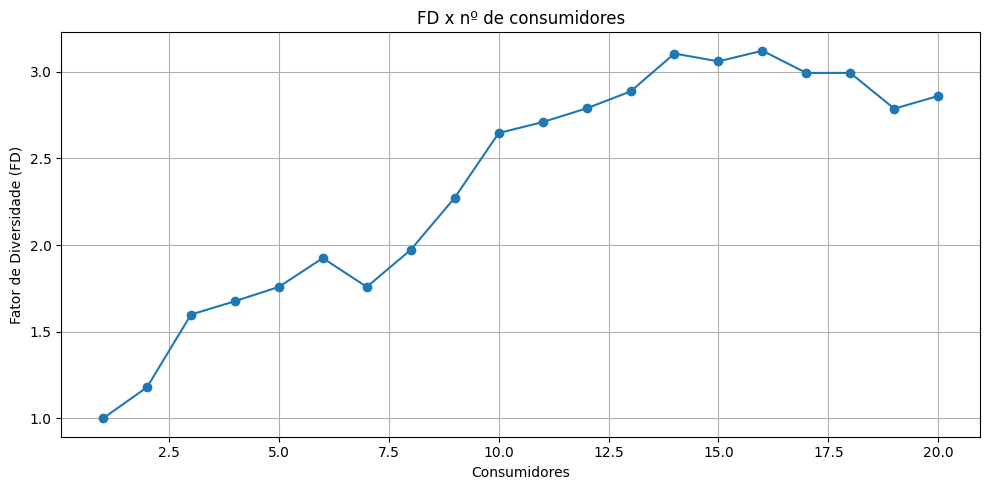

In [46]:
#Gerando gráfico que relaciona o número de consumidores com o FD
n_consumidores = loads_20_df.shape[0]
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_consumidores + 1), fd_tabela, marker='o')
plt.xlabel('Consumidores')
plt.ylabel('Fator de Diversidade (FD)')
plt.title('FD x nº de consumidores')
plt.grid(True)
plt.tight_layout()
plt.show()

Itens 3) e 4):

 Para estimar a Demanda Diversificada Máxima para o total de 55 consumidores, é necessário estimar o Fator de Diversidade primeiramente.

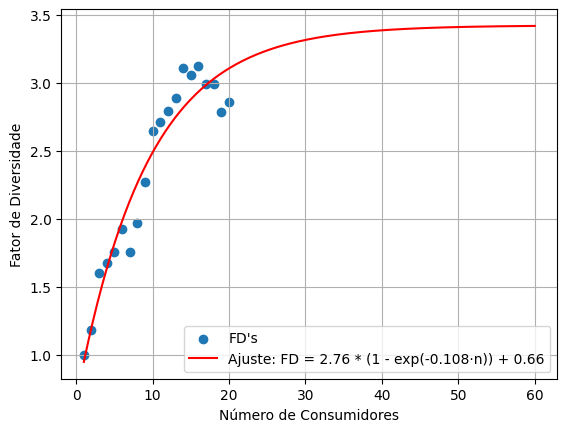

In [161]:
#Estimação exponencial:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

y = fd
x = np.arange(1, len(y)+1)

def modelo_offset(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

param, _ = curve_fit(modelo_offset, x, y, p0=[max(y), 0.05, 0])
a, b, c = param

xn = np.linspace(min(x), 60, 200)
yn = modelo_offset(xn, a, b, c)

plt.scatter(x, y, label='FD\'s')
plt.plot(xn, yn, 'r-', label=f'Ajuste: FD = {a:.2f} * (1 - exp(-{b:.3f}·n)) + {c:.2f}')
plt.xlabel('Número de Consumidores')
plt.ylabel('Fator de Diversidade')
plt.legend()
plt.grid(True)
plt.show()

In [162]:
fd_55 = modelo_offset(55, a, b, c)
print(f"Fator de diversificada estimado para 55 consumidores: {fd_55:.4f}")

Fator de diversificada estimado para 55 consumidores: 3.4144


In [165]:
#Retornando o DF com as 55 cargas:
loads_df_new = loads_df_new.T
loads_df_new

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.036000,0.036000,0.036000,0.160800,0.209600,0.105600,0.036000,0.036000,0.036000,0.080267,...,0.421067,0.344000,0.408000,0.514400,0.546667,0.384933,0.332800,0.254000,0.192000,0.098400
1,0.044000,0.044000,0.085067,0.198000,0.054267,0.130267,0.323467,0.207667,0.063400,0.136400,...,0.895733,1.006467,0.971067,0.730933,0.801267,0.789933,1.008933,1.146133,1.114800,1.506200
2,0.054000,0.054000,0.054000,0.054000,0.054000,0.054000,0.054000,0.054000,0.054000,0.054000,...,0.999267,0.562200,0.562133,2.747400,1.033733,0.440000,0.791067,1.066733,1.152133,0.581467
3,0.191200,0.228333,0.165667,0.166000,0.063733,0.167333,0.215600,0.257333,0.126667,0.048000,...,0.143467,0.475400,0.823600,0.515467,0.292733,0.203133,0.202600,0.179000,0.182200,0.048000
4,0.073667,0.035000,0.221667,0.035000,0.035000,0.035000,0.075000,0.181667,0.035000,0.035000,...,1.248133,0.555333,0.624267,0.712267,0.819467,0.580000,0.501200,0.423600,0.475333,0.459533
5,0.052000,0.052000,0.052000,0.052000,0.052000,0.113867,0.284000,0.098400,0.052000,0.052000,...,0.052000,0.268533,0.175733,0.052000,0.052000,0.175733,0.268533,0.052000,0.052000,0.052000
6,0.055000,0.055000,0.055000,0.106333,0.209000,0.075533,0.055000,0.055000,0.075533,0.209000,...,0.986333,0.858800,0.730333,0.752533,2.058000,3.997933,0.696000,0.681733,0.055000,0.055000
7,0.043000,0.054333,0.190333,0.116733,0.316333,0.179400,0.043000,0.201667,0.043000,0.074600,...,0.482800,0.382800,0.190467,0.043000,0.043000,0.201667,0.174067,0.602533,3.332933,3.206067
8,0.059000,0.177400,0.266200,0.059000,0.059000,0.198200,0.151800,0.059000,0.251400,0.192200,...,0.827067,0.511000,1.005000,0.411800,0.420200,0.103400,0.059000,0.117000,0.307000,0.281000
9,0.057000,0.057000,0.057000,0.057000,0.057000,0.101800,0.146600,0.057000,0.057000,0.146600,...,0.685200,1.657867,3.011133,0.742267,0.738867,0.693000,0.497533,0.057000,0.086867,0.161533


In [216]:
#Demanda Máxima Não Coincidente das Cargas ligadas ao Trafo:
dmnco_trafo = loads_df_new.max(axis=1).sum()
dmnco_trafo

np.float64(148.40766666666664)

In [170]:
#Estimando a Demanda Máxima do Trafo

In [217]:
ddm_tr1_est1 = dmnco_trafo / fd_55
print(ddm_tr1_est1)

43.46509442400693


In [218]:
#retornando a potência ativa no trafo:
p3_trafo

,Potência Ativa (kW)
0,3.047402
1,3.055018
2,3.238972
3,3.655860
4,4.093180
...,...
1435,16.374350
1436,14.136860
1437,13.886620
1438,13.583220


In [219]:
#Demanda no Trafo:
trafo_df_new = p3_trafo.groupby(np.arange(loads_df.shape[0]) // 15).mean()

In [220]:
trafo_df_new

,Potência Ativa (kW)
0,4.536486
1,6.206518
2,6.525025
3,7.562471
4,7.157054
...,...
91,31.575943
92,21.053410
93,17.154810
94,16.862901


In [221]:
#Demanda Máxima no Trafo:
dmax_trafo = trafo_df_new.max()
dmax_trafo

,0
Potência Ativa (kW),43.424038


In [222]:
#Estimando a Demanda Máxima no Trafo com Fator de Carga calculado para
#os 20 consumidores aleatórios:
dmeantotal_55 = loads_df_new.sum(axis=0).mean()
ddm_tr1_est2 = dmeantotal_55 / FCtotal
ddm_tr1_est2

np.float64(48.73617032064328)

#Análise dos Resultados:

In [223]:
results_4 = pd.DataFrame({
     "Valor Simulado": [float(dmax_trafo)],
     "Método FD": [float(ddm_tr1_est1)],
     "Erro no Método FD (%)": [abs((float(dmax_trafo)-float(ddm_tr1_est1))/float(dmax_trafo))*100],
     "Método FC": [float(ddm_tr1_est2)],
     "Erro no Método FC (%)": [abs((float(dmax_trafo)-float(ddm_tr1_est2))/float(dmax_trafo))*100]
}, index=["Demanda Máxima (kW)"])

p_df(results_4)

<ipython-input-223-3f8421c0a06e>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Valor Simulado": [float(dmax_trafo)],
<ipython-input-223-3f8421c0a06e>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Erro no Método FD (%)": [abs((float(dmax_trafo)-float(ddm_tr1_est1))/float(dmax_trafo))*100],
<ipython-input-223-3f8421c0a06e>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Erro no Método FC (%)": [abs((float(dmax_trafo)-float(ddm_tr1_est2))/float(dmax_trafo))*100]


,Valor Simulado,Método FD,Erro no Método FD (%),Método FC,Erro no Método FC (%)
Demanda Máxima (kW),43.424038,43.465094,0.094548,48.736170,12.233161


Dimensionando o Trafo com o Método do FD:

In [213]:
#Considerando FP = 0.9
FP = 0.9
KVA_TRAFO = ddm_tr1_est1 / FP
print(KVA_TRAFO)

48.29454936000769


Para dimensionar o Trafo nesse caso, o método do FC não é uma boa abordagem. O fato das cargas apresentarem baixa demanda média, mas demandas máximas consideráveis e o fato de que desses picos de demanda ocorrem em horários diferentes, fazem com que a curva de Demanda Diversificada apresente uma demanda média proporcionalmente mais elevada. Desse modo, ao se utilizar o FC a Demanda Máxima será superestimada.

In [210]:
#A tabela a seguir indica as Demanda Máximas individuais
#das 20 cargas selecionadas e em qual intervalo ocorrem:
intervalo_max = loads_20_df.idxmax(axis=1)
intervalo_max = loads_20_df.idxmax(axis=1)
frequencia_intervalos = intervalo_max.value_counts()
intervalos_unicos = frequencia_intervalos[frequencia_intervalos == 1].index

mascara_nao_coincidente = intervalo_max.isin(intervalos_unicos)
mascara_coincidente = ~mascara_nao_coincidente

df_nao_coincidentes = pd.concat([
    dmax[mascara_nao_coincidente].rename("Demanda Máxima (kW)"),
    intervalo_max[mascara_nao_coincidente].rename("Intervalo de Pico")
], axis=1)

df_coincidentes = pd.concat([
    dmax[mascara_coincidente].rename("Demanda Máxima (kW)"),
    intervalo_max[mascara_coincidente].rename("Intervalo de Pico")
], axis=1)

df_resultado = pd.concat([df_nao_coincidentes, df_coincidentes])

df_resultado = df_resultado.astype(float)

p_df(df_resultado)

,Demanda Máxima (kW),Intervalo de Pico
0,3.393133,72.000000
1,2.426200,30.000000
4,0.687333,92.000000
5,1.655267,65.000000
6,1.677000,36.000000
7,2.868067,29.000000
8,3.620333,77.000000
9,3.951267,71.000000
10,4.482200,80.000000
11,2.590467,35.000000


In [ ]:
#Como indicado na tabela, apenas em 4 consumidores dos 20 selecionados ocorre
#simultaneidade na Demanda Máxima.